In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
errors = (
    "face not recognized",
    "RuntimeError",
    "TypeError",
    
)

In [3]:
class metrics():
    
    def __init__(
        self,
        df: pd.DataFrame, 
        distance_column_name: str, 
        target_column_name: str,
        threshold: float
    ):
        self.values = np.array([
            1 if x >= threshold else 0 for x in df[distance_column_name]
        ])
        self.target = df[target_column_name]

        self.p_mask = self.target == 1
        self.n_mask = self.target == 0
    
    def tp_fp_tn_fn(self):
        tp = sum(                               #true_positive
            self.target[self.p_mask] == self.values[self.p_mask]
        )

        fp = sum(                               #false_positive
            self.target[self.p_mask] != self.values[self.p_mask]
        )

        tn = sum(                               #true_negative
            self.target[self.n_mask] == self.values[self.n_mask]
        )

        fn = sum(                               #false_negative
            self.target[self.n_mask] != self.values[self.n_mask]
        )
        return (tp, fp, tn, fn)
    
    def precision_recall(self):
        tp, fp, tn, fn = self.tp_fp_tn_fn()

        precision = tp/(tp+fp)
        recall = tp/(tp+fn)

        return precision, recall
    
    def accuracy(self):
        tp, fp, tn, fn = self.tp_fp_tn_fn()

        accuracy = (tp + tn)/(tp+fp+tn+fn)

        return accuracy

    def f1(self):
        precision, recall = self.precision_recall()

        f1 = 2 * (precision * recall) / (precision + recall)

        return f1 

# Ноутбук с экспериментами

## В этом ноутбуке будет описываться ход экспериментов и результаты

Данные были взяты из датасета [VGG-Face2](https://paperswithcode.com/paper/vggface2-a-dataset-for-recognising-faces)

Батч взятый из датасета включал 120 персон и ~43 000 фото

Фотографии и субъекты выбирались случайно с помощью np.random.choice 

-----

### res_net - для работы с лицами
### mtcnn для вырезания лиц

#### Experiment 1

Стандартные гиперпараметры

In [4]:
data = pd.read_pickle("./res_net_mtcnn_vgg__exp1.pkl")

In [5]:
df = pd.DataFrame(
    data=data
).T

In [6]:
# выбираю неошибочные значения
df = df.loc[~df.results.isin(errors)].copy()

In [7]:
df.shape

(2514, 6)

In [8]:
df.head()

,person_1,person_1_photo,person_2,person_2_photo,results,froad
7,n000066,0198_01.jpg,n000132,0141_02.jpg,{'euclidean': 0.64907104},1
8,n000032,0388_01.jpg,n000032,0374_01.jpg,{'euclidean': 0.8555268},0
10,n000066,0355_03.jpg,n000066,0198_01.jpg,{'euclidean': 0.6932242},0
12,n000130,0378_03.jpg,n000130,0093_01.jpg,{'euclidean': 0.70193166},0
18,n000099,0111_03.jpg,n000099,0279_02.jpg,{'euclidean': 0.33964255},0


In [9]:
df["euclidean_distance"] = df.results.apply(lambda x: x['euclidean'])

In [10]:
df.head()

,person_1,person_1_photo,person_2,person_2_photo,results,froad,euclidean_distance
7,n000066,0198_01.jpg,n000132,0141_02.jpg,{'euclidean': 0.64907104},1,0.649071
8,n000032,0388_01.jpg,n000032,0374_01.jpg,{'euclidean': 0.8555268},0,0.855527
10,n000066,0355_03.jpg,n000066,0198_01.jpg,{'euclidean': 0.6932242},0,0.693224
12,n000130,0378_03.jpg,n000130,0093_01.jpg,{'euclidean': 0.70193166},0,0.701932
18,n000099,0111_03.jpg,n000099,0279_02.jpg,{'euclidean': 0.33964255},0,0.339643


In [11]:
df.sort_values('euclidean_distance', inplace=True)

In [13]:
df.froad.sum()

923

In [15]:
prec = []
rec = []
for threshold in np.arange(start=0, stop=max(df.euclidean_distance), step=0.001):
    metric = metrics(
        df, 
        'euclidean_distance', 
        'froad', 
        threshold
    )
    precision, recall = metric.precision_recall()
    prec.append(precision)
    rec.append(recall)

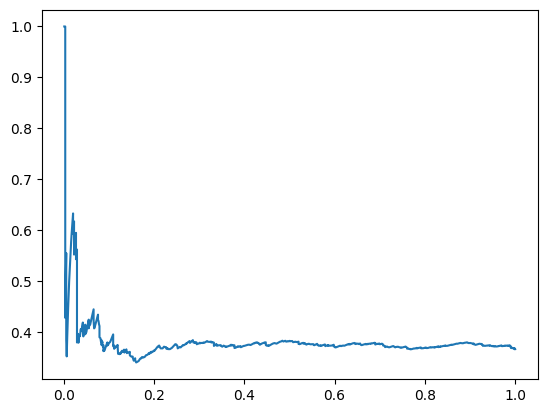

In [16]:
fig, ax = plt.subplots()
ax = plt.plot(prec, rec)

In [17]:
f1 = []
for threshold in np.arange(start=0, stop=max(df.euclidean_distance), step=0.001):
    metric = metrics(
        df, 
        'euclidean_distance', 
        'froad', 
        threshold
    )
    acc = metric.f1()
    f1.append(acc)

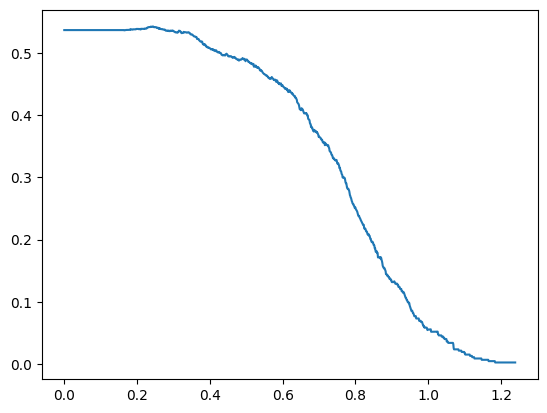

In [18]:
fig, ax = plt.subplots()
ax = plt.plot(
    np.arange(start=0, stop=max(df.euclidean_distance), step=0.001), 
    f1
)

### В общем и целом, можно сказать, что результаты ни к чему не привели. Скорее всего проблема в выборке фотографий, которые могут быть очень плохие. Возможно, стоит руками выбрать фотографии для следующего теста т.к. фотографии могут быть очень плохого качества.